# Import Libraries

In [5]:
!pip install wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   -- ------------------------------------ 20.5/300.2 kB 640.0 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/300.2 kB 812.7 kB/s eta 0:00:01
   ------------------------------ --------- 225.3/300.2 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.3 MB/s eta 0:00:00


In [28]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import eda_helper_functions
from sklearn.ensemble import IsolationForest

## 1. Read the Training Data

In [8]:
file_path=r"C:\Users\Souvik Karmakar\OneDrive - kiit.ac.in\Desktop\Flight Price Prediction (sagemaker)\data\train.csv"
train=pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [9]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [18]:
train=train.assign(**{
    col: pd.to_datetime(train.loc[:, col],dayfirst=True,format="mixed").dt.time
    for col in ["date_of_journey", "dep_time", "arrival_time"]
})
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,00:00:00,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,00:00:00,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,00:00:00,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,00:00:00,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,00:00:00,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,00:00:00,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,00:00:00,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,00:00:00,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,00:00:00,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [15]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## 2. High-level Summary of the data

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


In [20]:
#High level Descriptive statistics for numerical variables
train.describe(include="number")

,duration,total_stops,price
count,6695.000000,6694.000000,6695.000000
mean,633.489171,0.801464,9030.965646
std,503.006311,0.659737,4639.522857
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,922.500000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [23]:
#total_stops we can consider it as categorical 
# Descriptive Statistics for object variables
(
    train
    .assign(total_stops=train.total_stops.astype(object))
    .describe(include="O")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info
count,6695,6695,6695,6695,6695,6695,6694.0,6695
unique,9,1,5,6,217,220,4.0,7
top,Jet Airways,00:00:00,Delhi,Cochin,18:55:00,19:00:00,1.0,No Info
freq,2391,6695,2730,2730,159,376,3580.0,5249


## 4. High-level Analysis of Missing Values

In [27]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


In [26]:
train.total_stops.fillna("0",inplace=True)

C:\Users\Souvik Karmakar\AppData\Local\Temp\ipykernel_34072\2325620208.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train.total_stops.fillna("0",inplace=True)


## 5. High-level Analysis of Outliers

In [30]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [32]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns="price")
                                       .select_dtypes(include="number")))
    .query("outlier == -1")
) # we can check this are genuine outliers are not by checking each and every features individually

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
5,Jet Airways,00:00:00,Banglore,Delhi,18:55:00,22:00:00,185,0.0,In-flight meal not included,4544,-1
7,Spicejet,00:00:00,Mumbai,Hyderabad,05:45:00,07:15:00,90,0.0,No check-in baggage included,2647,-1
9,Jet Airways,00:00:00,Delhi,Cochin,23:05:00,04:25:00,1760,2.0,No Info,15129,-1
10,Jet Airways,00:00:00,Kolkata,Banglore,14:05:00,10:05:00,1200,1.0,No Info,13044,-1
12,Jet Airways,00:00:00,Delhi,Cochin,21:25:00,19:00:00,1295,2.0,No Info,13292,-1
...,...,...,...,...,...,...,...,...,...,...,...
6688,Jet Airways,00:00:00,Delhi,Cochin,21:25:00,12:35:00,910,2.0,In-flight meal not included,9905,-1
6689,Indigo,00:00:00,Mumbai,Hyderabad,09:10:00,10:40:00,90,0.0,No Info,5755,-1
6690,Jet Airways,00:00:00,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093,-1
6693,Air Asia,00:00:00,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152,-1


## 6. Pair plots

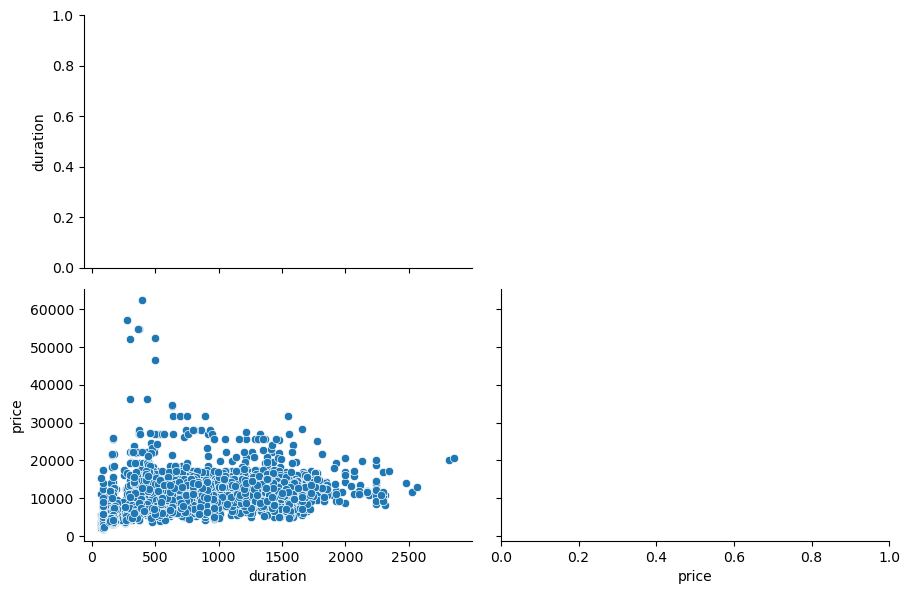

In [33]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

In [36]:
pip install --upgrade seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   -------- ------------------------------ 61.4/294.9 kB 648.1 kB/s eta 0:00:01
   --------------------------- ------------ 204.8/294.9 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
Note: you may need to restart the kernel to use updated packages.


In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


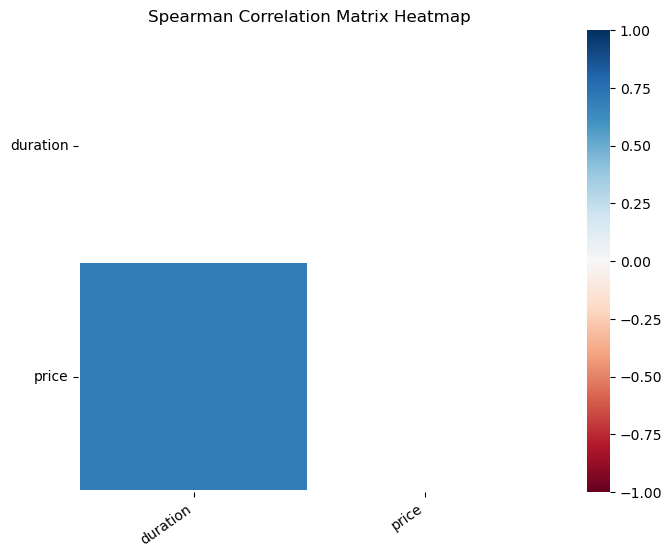

In [38]:
eda_helper_functions.correlation_heatmap(train)

In [39]:
train.corr(method="spearman",numeric_only=True)

,duration,price
duration,1.00000,0.69786
price,0.69786,1.00000


C:\Users\Souvik Karmakar\OneDrive - kiit.ac.in\Desktop\Flight Price Prediction (sagemaker)\notebooks\eda_helper_functions.py:350: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))
C:\Users\Souvik Karmakar\OneDrive - kiit.ac.in\Desktop\Flight Price Prediction (sagemaker)\notebooks\eda_helper_functions.py:350: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))
C:\Users\Souvik Karmakar\OneDrive - kiit.ac.in\Desktop\Flight Price Prediction (sagemaker)\notebooks\eda_helper_functions.py:350: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))
C:\Users\Souvik Karmakar\OneDrive - kiit.ac.in\Desktop\Flight Price Prediction (sagemaker)\notebooks\eda_helper_functions.py:350: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))
C:\Users\Souvik Karmakar\OneDrive - kiit.ac.in\Desktop\Fligh

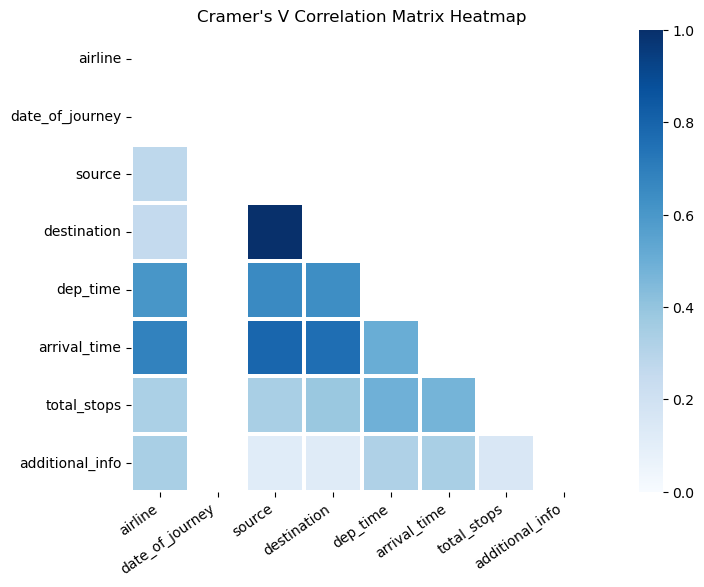

In [41]:
eda_helper_functions.cramersV_heatmap(train)